# In this notebook, we show the steps taken to preprocess the **genes** expression data, generate and select features through feature selection strategies which include lasso, mrmr, fisher score thresholds, mutual information score thresholds and the new proposed method **ReRa**. After this, different models are tuned and evaluated in the classification task using training and test dataset.



Related links:

correlation pearson:
https://towardsdatascience.com/what-it-takes-to-be-correlated-ce41ad0d8d7f

https://towardsdatascience.com/pearson-coefficient-of-correlation-explained-369991d93404

https://medium.com/@joseph.magiya/pearson-coefficient-of-correlation-using-pandas-ca68ce678c04


fisher score:
https://jundongl.github.io/scikit-feature/tutorial.html

https://ranasinghiitkgp.medium.com/implementing-feature-selection-methods-for-machine-learning-bfa2e4b4e02

mutual information:
https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
# uncomment to install libraries
! pip install mrmr_selection
! pip install scikit-learn==0.24.2 # Downgrading the scikit learn library to obtain same results of previous experiments and Convergence

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from pandas_profiling import ProfileReport
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from datetime import datetime
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import mrmr
# select top K features using mRMR
from mrmr import mrmr_classif
import seaborn as sb
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

### Download of all datasets with different preprocessing strategies and feature spaces

In [ ]:
# Current working directory and other paths
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/"
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/"

# Dataset with gene expression 
gene_dataset = pd.read_csv(path+"gene_expression_data_and_metadata/data_mrna_seq_v2_rsem.txt" , index_col= 0 , sep='\t') 
gene_dataset = gene_dataset.transpose() # (818, 20440)
# remove first column about entrez_gene_id
gene_dataset = gene_dataset.iloc[1: , :]
print(gene_dataset.shape)
# Training and Testing datasets
training_ds =  pd.read_excel(path+"train_test_new.xlsx", sheet_name="train_new")
testing_ds = pd.read_excel(path+"train_test_new.xlsx", sheet_name="test_new")

/content
(817, 20440)


In [ ]:
# feature spaces 
pam_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/PAM50.txt" , index_col= 0 , sep='\t') 
limma_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/LIMMA50.txt" , index_col= 0 , sep='\t') 

pam_fs.reset_index(inplace=True)
limma_fs.reset_index(inplace=True)

### Preprocessing section: create the CPM Matrix

In [ ]:
cpm_dataset_1 = gene_dataset.div(gene_dataset.sum(axis=1), axis=0)
cpm_dataset_end = cpm_dataset_1 * 1000000
cpm_dataset = cpm_dataset_end
cpm_dataset.shape

(817, 20440)

In [ ]:
cpm_dataset.columns.name = ''
cpm_dataset.index.rename('sample_id', inplace=True)
cpm_dataset.index = cpm_dataset.index.str[: -3] # removal of -01 from cpm sample id which is not relevant for recognition
cpm_dataset.head()

#### filtering the genes that have expression data at the beginning lower than 4 for more than 80% of the samples.

In [ ]:
y = (gene_dataset[gene_dataset < 4].count() /818 > 0.8)
y = y[y==True]
y = y.reset_index()
print(y[''])

In [ ]:
gene_dataset.drop(y[''], axis=1, inplace=True)
gene_dataset.head()

In [ ]:
cpm_dataset.drop(y[''], axis=1, inplace=True)
cpm_dataset.head()

#### Evaluation of the median values

In [ ]:
med = cpm_dataset.median()
med.sort_values(inplace=True)
md = pd.DataFrame(med)
md.describe()

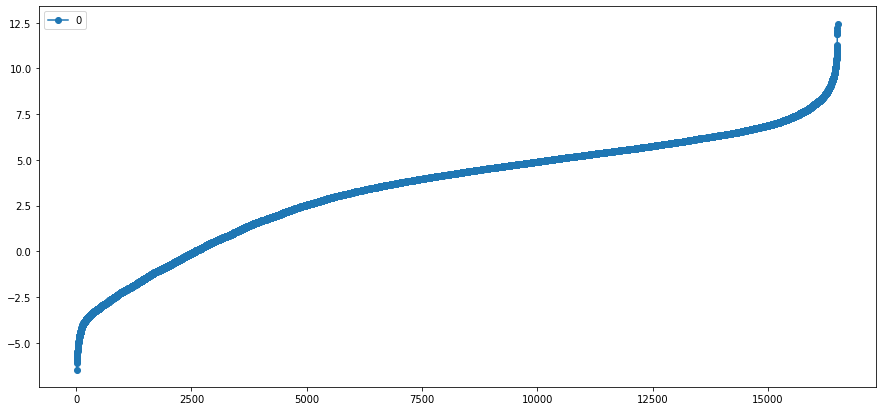

In [ ]:
%matplotlib inline
log_md = np.log2(md)
log_md.reset_index(drop=True).plot(figsize=(15,7), style='o-')

In [ ]:
md = md[md>3.38]
md.dropna(inplace=True)
gene_to_keep_by_median = md.index.tolist()
gene_to_keep_by_median

In [ ]:
# keeping just the filtered by removing the ones with median value lower than the 25% from the describe
cpm_dataset = cpm_dataset[np.intersect1d(cpm_dataset.columns, gene_to_keep_by_median)]

In [ ]:
cpm_dataset.head()

,A1BG,A1BG-AS1,A2M,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,2.493770,3.801738,1603.081519,17.103149,36.078739,110.702352,6.005511,43.020468,53.136219,7.750306,...,24.064519,16.281099,4.863782,26.328346,71.769285,0.981892,69.166137,313.588163,97.892120,72.796846
TCGA-A1-A0SD,7.670497,7.743075,1282.579083,20.329587,28.425758,42.299809,8.666822,105.232365,59.579958,27.801602,...,20.076537,34.970458,5.189397,31.172037,66.071162,1.783299,46.793718,191.882778,68.942268,64.448359
TCGA-A1-A0SE,10.234784,7.888537,834.862431,14.131281,33.782319,44.123136,5.519757,87.530094,53.782712,19.004741,...,23.436790,43.040141,5.065602,38.568442,54.079661,3.056830,50.987894,159.653775,49.171264,57.084085
TCGA-A1-A0SF,17.274740,9.924330,825.746478,23.380748,53.276323,23.471546,4.721547,53.367122,35.139223,16.434623,...,14.153295,35.865614,3.927056,28.261196,55.818696,5.016646,46.693397,283.134039,49.508164,26.921912
TCGA-A1-A0SH,7.732152,6.762265,600.218980,14.943977,22.470162,35.168673,5.001973,58.041472,50.979863,11.862264,...,17.245967,14.851062,3.763095,24.916952,34.363403,0.851729,58.025988,234.333928,56.291558,42.927153


In [ ]:
cpm_dataset.shape

(817, 12385)

### Utils support functions

In [ ]:
def extract_and_reduce_by_columns(full_df, nofeats_ds, preproc_strategy: str= "none"): 
  """
     Function to extract dataset and a specific group of its columns.

     path: the path where to get the data values (isoforms)
     sheet_name: the excel sheet were to get the columns to select for the data (isoforms)
     nofeats_ds: the dataset without the additional columns
     name: 'trainingset' or 'testingset' for the excel 
     preproc_strategy: which preprocessing strategy to apply to the ds

  """
  full_df = full_df # path of subdatset 
  full_list= full_df['Genes'].values.tolist()  #exatrct the list of isoforms names as list
  if preproc_strategy == 'loge':
    # https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p
    log_cpm_dataset = np.log1p(cpm_dataset)
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'log2':
    log_cpm_dataset = np.log2(cpm_dataset + 1) # constant added to avoid reaching zero
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'normperrow':
    # normalize per rows
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]
    data = data.div(data.sum(axis=1), axis=0) # ----> preprocessing scaling step to try, not working
  elif preproc_strategy == 'none':
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
    
  
  #data.reset_index(inplace=True) # todo remove
  #data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True) 
  # print("hello", data.index)
  x = nofeats_ds['sample_id'].values.tolist()
  data1= data.loc[data.index.isin(x)]
  # print("hello11", data1)
  result = pd.merge(data1, nofeats_ds, on='sample_id')
  result
  result.rename(columns={'sample_label':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

In [ ]:
# This functions shows the evaluation results for the entire test set and also the metrics for each single class

def show_single_class_evaluation(y_pred: int, y_test: int, labels):
  print("Balanced accuracy: ", round(balanced_accuracy_score(y_test, y_pred), 3)) # not possible for single class
  print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3)) # not possible for single class
  print('precision ', round(precision_score(y_test, y_pred, average="macro"), 3))
  print('recall ', round(recall_score(y_test, y_pred, average="macro"), 3))
  print('f1_macro ', round(f1_score(y_test, y_pred, average="macro"),3))
  print('f1_micro ', round(f1_score(y_test, y_pred, average="micro"),3))
  print("Precision: ", [round(i, 3) for i in precision_score(y_test, y_pred, average=None) ])
  print("Recall: ",  [round(i, 3) for i in recall_score(y_test, y_pred, average=None) ]) 
  print("F1 Score: ", [round(i, 3) for i in f1_score(y_test, y_pred, average=None) ]) 
  print('--------------------------------------------')

  dic_result = {}
  dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_test, y_pred), 3)]
  dic_result['accuracy'] = [round(accuracy_score(y_test, y_pred), 3)]
  for i in range(len(labels)):
    dic_result[labels[i]+'-precision'] =  round( precision_score(y_test, y_pred, average=None)[i], 3)
  for i in range(len(labels)):
    dic_result[labels[i]+'-recall'] =  round( recall_score(y_test, y_pred, average=None)[i], 3)
  for i in range(len(labels)):   
    dic_result[labels[i]+'-f1_score'] =  round( f1_score(y_test, y_pred, average=None)[i], 3)
  
  df_result = pd.DataFrame.from_dict(dic_result)
  df_result.to_excel('output_detailed_scores.xlsx')
  print(df_result)

In [ ]:
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

In [ ]:
# Here the train and test set are created with the initial filterings to reach 49k features is 
# Training Data import:
train = extract_and_reduce_by_columns(main_filtered_gene_fs, training_ds, 'log2') 
X_train_49kfs = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train_49kfs=train.subtype
print("X_train size:", X_train_49kfs.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(main_filtered_gene_fs,  testing_ds,  'log2') 
X_test_49kfs = test.drop(["sample_id","subtype"], axis = 1)
Y_test_49kfs = test.subtype
print("X_test size:", X_test_49kfs.shape)

X_train size: (410, 12385)
X_test size: (127, 12385)


DATASET with PAM50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'log2') 
X_train_pam_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_log2 =train.subtype
print("X_train size:", X_train_pam_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds, 'none') 
X_test_pam_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_log2 = test.subtype
print("X_test size:", X_test_pam_log2.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET with LIMMA50 Feature Space and LOG2 PREPROCESSING

In [ ]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'log2') 
X_train_limma_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_log2 =train.subtype
print("X_train size:", X_train_limma_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'log2') 
X_test_limma_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_log2 = test.subtype
print("X_test size:", X_test_limma_log2.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET with features selected throgh LASSO REGRESSION from PAM50 and LOG2 PREPROCESSING

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_pam_log2,Y_train_pam_log2)
sel_.get_support()
selected_feat = X_train_pam_log2.columns[(sel_.get_support())]

In [ ]:
print('total features: {}'.format((X_train_pam_log2.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('Percentage features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)/131*5))

total features: 49
selected features: 48
Percentage features with coefficients shrank to zero: 4.0458015267175576


In [ ]:
X_train_pam_log2_sel = X_train_pam_log2[selected_feat].copy()
Y_train_pam_log2_sel = Y_train_pam_log2

X_test_pam_log2_sel = X_test_pam_log2[selected_feat].copy()
Y_test_pam_log2_sel = Y_test_pam_log2

DATASET with features selected throgh LASSO REGRESSION from LIMMA50 and LOG2 PREPROCESSING

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_limma_log2,Y_train_limma_log2)
sel_.get_support()
selected_feat = X_train_limma_log2.columns[(sel_.get_support())]

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [ ]:
print('total features: {}'.format((X_train_limma_log2.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('Percentage features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)/557*5))

total features: 185
selected features: 143
Percentage features with coefficients shrank to zero: 5.8886894075403955


In [ ]:
X_train_limma_log2_sel = X_train_limma_log2[selected_feat].copy()
Y_train_limma_log2_sel = Y_train_limma_log2

X_test_limma_log2_sel = X_test_limma_log2[selected_feat].copy()
Y_test_limma_log2_sel = Y_test_limma_log2

## Random selection of 10 feature spaces

In [ ]:
import random

In [ ]:
random_feature_spaces = []
X_train_randoms = []
X_test_randoms =[]

for i in range(10):
  random_fs = random.sample(list(X_train_49kfs.columns), 320)
  random_feature_spaces.append(random_fs)

  selected_col_names =random_fs
  X_train_random = X_train_49kfs[selected_col_names]
  print("Shape of the new train dataset", X_train_random.shape)

  test_selected_col_names = random_fs
  X_test_random = X_test_49kfs[selected_col_names]
  print("Shape of the new test dataset",X_test_random.shape)

  X_train_randoms.append(X_train_random)
  X_test_randoms.append(X_test_random)

Shape of the new train dataset (410, 321)
Shape of the new test dataset (127, 321)
Shape of the new train dataset (410, 321)
Shape of the new test dataset (127, 321)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)
Shape of the new train dataset (410, 321)
Shape of the new test dataset (127, 321)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)
Shape of the new train dataset (410, 320)
Shape of the new test dataset (127, 320)


In [ ]:
dic_intersect = {}
for x,name in zip(random_feature_spaces, range(10)):
  dic_intersect[name]= []
  for y in random_feature_spaces:
    dic_intersect[name].append(len(set(x).intersection(y)))
  
  print(f"Number of genes intersected with the others in feature space : {name} is { dic_intersect[name]}")

Number of isforms intersected with the others in feature space : 0 is [320, 7, 11, 7, 14, 9, 13, 9, 7, 5]
Number of isforms intersected with the others in feature space : 1 is [7, 320, 13, 11, 9, 11, 9, 9, 10, 8]
Number of isforms intersected with the others in feature space : 2 is [11, 13, 320, 10, 7, 6, 7, 6, 6, 10]
Number of isforms intersected with the others in feature space : 3 is [7, 11, 10, 320, 10, 8, 7, 10, 11, 4]
Number of isforms intersected with the others in feature space : 4 is [14, 9, 7, 10, 320, 13, 7, 7, 6, 9]
Number of isforms intersected with the others in feature space : 5 is [9, 11, 6, 8, 13, 320, 12, 9, 7, 10]
Number of isforms intersected with the others in feature space : 6 is [13, 9, 7, 7, 7, 12, 320, 7, 9, 9]
Number of isforms intersected with the others in feature space : 7 is [9, 9, 6, 10, 7, 9, 7, 320, 9, 1]
Number of isforms intersected with the others in feature space : 8 is [7, 10, 6, 11, 6, 7, 9, 9, 320, 5]
Number of isforms intersected with the others

In [ ]:
Y_train_random = Y_train_49kfs
Y_test_random = Y_test_49kfs

## For the paper methodological anlysis, furhter feature spaces will be included which are: 
1. selection of features through fisher score
2. selection of features through mutual information
3. selection of features through ReRa, having as initial feature speces pam50 ,limma50, fisher score and mutual information with diferent thresholds


In [ ]:
from scipy.optimize.optimize import main
main_filtered_gene_fs = pd.DataFrame({'Genes': cpm_dataset.columns.tolist()})

### Feature space with Fisher Score ( and log2 preprocessing)

In [ ]:
# in order to compute the fisher score we need to clone and use this github project with uses sklearn to compute it
! git clone https://github.com/jundongl/scikit-feature.git
%cd scikit-feature/
! python setup.py install

In [ ]:
import skfeature
import skfeature.function.similarity_based.fisher_score as fisher_score
# computing all fisher scores for all 49k features
score = fisher_score.fisher_score(X_train_49kfs.values, Y_train_49kfs.values)
score.sort()
score_dataframe = pd.DataFrame(score)

In [ ]:
score_dataframe.describe([0.75, 0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99])

,0
count,12385.000000
mean,0.166995
std,0.203545
min,0.000566
50%,0.104519
75%,0.206110
80%,0.244010
85%,0.293998
90%,0.376199
95%,0.528145


In [ ]:
score_97 = score_dataframe.describe([ 0.92])
score_97[score_97.index == '92%'].values[0][0]

0.42076965443491526

In [ ]:
# by keeping the features with score in the highest 99 (before 95) percentile we can reach a reduced number of features of 2492
print(score_dataframe[score_dataframe[0]>0.652313])

              0
12013  0.652387
12014  0.652768
12015  0.653039
12016  0.654043
12017  0.654577
...         ...
12380  2.847997
12381  3.329098
12382  3.508824
12383  3.753524
12384  6.303571

[372 rows x 1 columns]


In [ ]:
fisher_score_selected_index = np.where(score >score_97[score_97.index == '92%'].values[0][0])[0]
selected_col_names = X_train_49kfs.columns[fisher_score_selected_index ]

In [ ]:
selected_col_names =pd.read_csv(path+"genesfs/genes_fisher_th99.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_col_names = selected_col_names['gene_id'].tolist()
len(selected_col_names)

124

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD CHOSEN IS THE 95% percentile value
X_train_fisher = X_train_49kfs[selected_col_names]
print(X_train_fisher.shape)

X_test_fisher = X_test_49kfs[selected_col_names]
print(X_test_fisher.shape)

# Y of the datasets remain the same
Y_train_fisher = Y_train_49kfs
Y_test_fisher = Y_test_49kfs

(410, 124)
(127, 124)


In [ ]:
pd.DataFrame(X_train_fisher.columns).to_csv(path+"/genes_fisher_th99.csv")

### Feature spaces from scores with mutual information

In [ ]:
import skfeature
from sklearn.feature_selection import mutual_info_classif as MIC
# Computing mutual information scores for all 49k features using the library
mi_score = MIC(X_train_49kfs,Y_train_49kfs)

In [ ]:
# checking length and scores computed with mutual info
print(mi_score)
print(len(mi_score))

[0.0754145  0.11693518 0.18340202 ... 0.07076669 0.06381537 0.        ]
12385


In [ ]:
mi_score_dataframe = pd.DataFrame(mi_score)
# with the describe we can se the distribution of the scores
mi_score_dataframe.describe([0.7, 0.8, 0.85, 0.92, 0.95, 0.97, 0.98, 0.99])

,0
count,12385.000000
mean,0.082154
std,0.071142
min,0.000000
50%,0.065655
70%,0.100318
80%,0.128393
85%,0.149049
92%,0.192268
95%,0.223910


In [ ]:
score_97 = mi_score_dataframe.describe([ 0.92])
score_97[score_97.index == '92%'].values[0][0]

0.19226840283254631

In [ ]:
mi_score_selected_index = np.where(mi_score >score_97[score_97.index == '92%'].values[0][0])[0]
selected_col_names = X_train_49kfs.columns[mi_score_selected_index ]

In [ ]:
len(selected_col_names)

991

In [ ]:
selected_col_names =pd.read_csv(path+"genesfs/mrmr750_from12k.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_col_names = selected_col_names['gene_id'].tolist()
len(selected_col_names)

750

In [ ]:
# Creating the new dataframe with only the chosen features by this method -> THRESHOLD IS TH 95% percentile

X_train_mi = X_train_49kfs[selected_col_names]
print(X_train_mi.shape)
X_test_mi = X_test_49kfs[selected_col_names]
print(X_test_mi.shape)

Y_train_mi = Y_train_49kfs
Y_test_mi = Y_test_49kfs

(410, 991)
(127, 991)


In [ ]:
pd.DataFrame(X_train_mi.columns).to_csv(path+"/genesfs/genes_mi_990f.csv")

In [ ]:
pd.DataFrame(X_train_mi.columns).to_csv(path+"/genes_mi_th99.csv")

## Similarity based filter -> analysis and selection

In [ ]:
# support function to find the median of the values in a column
def find_median_less_than_one(df, col_name):
    # Get only the values in the column that are less than 1
    values = df[df[col_name] < 1][col_name]
    # Compute the median of the values
    median = values.median()
    return median

In [ ]:
# support function to find the waste (difference between max median and min median local)
def find_deviation_value(dfs, col_name):
  median_values = []
  for df in dfs:
    m =  find_median_less_than_one(df, col_name)
    median_values.append(m)
  return max(median_values) - min(median_values)

In [ ]:
def sbf_analysis(X, Y, additional_link: bool=False, link_mask= None ):
  # computing the correlation matrix with pearson correlation from the train set with 49k features 
  ##### current issue -> ram crashes because computation power is not enough -> reduced to 30k
  pc_global = X.corr()
  
  # checking the scores in the pearson correlation
  print(pc_global.describe())
  # more information about the distribution of the correlations
  # print(pc_global.describe())
  # to display the correlation matrix let's plot and show them with a heatmap
  '''sb.heatmap(pearson_corr, 
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
  '''

  # find median after removing values equal to 1 or duplicated ones 
  values = pc_global.values
  # get only the vlaues under the diagonal (since simmetric matrix with duplicated values) to compute the global stats
  lower_triangular = values[np.tril_indices(values.shape[0], -1)]
  flatten = lower_triangular.flatten()
  flatten_df = pd.DataFrame(flatten)
  flatten_df = flatten_df[flatten_df <1]
  # compute global median and save it
  global_median = np.median(flatten_df)
  print("Global median:", global_median)

  pc_global[ pc_global ==1] =  0

  print("Per class correlation with pearson: \n\n")

  local_medians_dic = {}
  local_pcs = {}
  # for each class in the classes available
  for name_class in Y.unique():
    print(name_class)
    # find the samples from the train assigned to that class
    sample_per_class = Y[Y==name_class]
    print("Samples with label:", len(sample_per_class))
    # choose the corresponding X assigned to the samples with as label the current class
    X_class = X.loc[sample_per_class.index]
    print(X_class.shape)
    # compute correlation matrix only for those samples
    class_corr = X_class.corr()
    # print("Correlation of class \n", class_corr)

    values = class_corr.values
    lower_triangular = values[np.tril_indices(values.shape[0], -1)]
    flatten = lower_triangular.flatten()
    flatten_df = pd.DataFrame(flatten)
    flatten_df = flatten_df[flatten_df <1]
    median_local = np.median(flatten_df)
    print("Local median:", median_local)
    
    class_corr[ class_corr ==1] =  0
    # saving in two dictionaries the information for the next steps of filtering
    # which are: pearson correlation matrices (complete) for only samples of each class
    # local median values for each of these "LOCAL" pearson correlation matrices
    local_pcs[name_class] = class_corr
    local_medians_dic[name_class]= median_local
  
  print(local_medians_dic)

  # now I have the global variables: class_corr which is the matrix with correlations and median_global which is the global median threshold
  # and the local variables which are the matrix of correlation with samples of each class and local median threshold for each one of them

  # Initialize array temp
  temp = []
  i = 0 # counter to check loop status
  # Loop through each column in matrix a
  for col in pc_global.columns:

      print("current feature: ", col, " we are ath the feature n.", i)
      i += 1
      # Check if all values in the column are less than median_a
      if all(pc_global[col] < global_median):
          print(col, "added to temp array")
          temp.append(col)
      else:
          # Find rows where values in the column are greater than or equal to the threshold
          # these means that these two features are similar and the scores have to be checked locally
          row_feats = pc_global[col][pc_global[col] >=  global_median].index.tolist() 

          for row_feat in row_feats:
             # assuimption: the two features are "also" locally similar 
              not_locally_similar = False
              # Check if all values in the corresponding columns of local matrices are less than their respective medians
              for c_name in local_pcs.keys():
                local_pc = local_pcs[c_name]
                local_median = local_medians_dic[c_name]
                if local_pc[col][row_feat] < local_median: # if all(local_pc[col] < local_median):
                  # if all values in the column of the local pearson correlation matrix are under the local threshold we can add both features (row_feat and col) in the temp
                  not_locally_similar = True
                  break
              
              if not_locally_similar:
                # print(col, row_feat, " have been added to temp since locally not similar")
                temp.append(col)
                temp.append(row_feat)
              else:
                # print("Choosing by looking at higher waste between two features")
                dev_col = find_deviation_value(list(local_pcs.values()), col)
                dev_row = find_deviation_value(list(local_pcs.values()), row_feat)
                # for the final choice of the feature two keep, looking at the maximum waste for each of the features and choosing the wider one
                if dev_col > dev_row:
                  temp.append(col)
                  # removing all values from temp that correspond to the feature with less waste
                  temp = list(filter(lambda a: a != row_feat, temp))
                else:
                  temp.append(row_feat)
                  temp = list(filter(lambda a: a != col, temp))

  print(temp)
  # removing duplicates
  temp_nodup = list(OrderedDict.fromkeys(temp))
  return temp_nodup

### Feature Space with SBF on PAM50-log2

In [ ]:
X_train_pam_log2.columns

In [ ]:
# output of the sbf analysis will be the list of filtered features
sbf_pam =  sbf_analysis(X_train_pam_log2,  Y_train_pam_log2)

In [ ]:
from collections import OrderedDict
sbf_nodup = list(OrderedDict.fromkeys(sbf_pam))
len(sbf_nodup)

for i in sbf_nodup:
  if i in X_train_pam_log2.columns:
    # print(i)
    x = 0
  else:
    print(i, "Not in ---> problem")

In [ ]:
selected_col_names = sbf_pam
# New x train dataset with only the selected features
X_train_pam_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_pam_sbf.shape)

test_selected_col_names = sbf_pam
# New x test dataset with only the selected features
X_test_pam_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_pam_sbf.shape)

Shape of the new train dataset (410, 41)
Shape of the new test dataset (127, 41)


In [ ]:
pd.DataFrame(X_train_pam_sbf.columns).to_csv(path+"/genesfs/genes_sbf_pam.csv")

### Feature Space with SBF on LIMMA50 log2

In [ ]:
# output of the sbf_analysis will be the lsit of selected features 
sbf_limma =  sbf_analysis(X_train_limma_log2,  Y_train_limma_log2)

In [ ]:
selected_col_names = sbf_limma
X_train_limma_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_limma_sbf.shape)

test_selected_col_names = sbf_limma
X_test_limma_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_limma_sbf.shape)

Shape of the new train dataset (410, 154)
Shape of the new test dataset (127, 154)


In [ ]:
pd.DataFrame(X_train_limma_sbf.columns).to_csv(path+"/genesfs/genes_sbf_limma.csv")

### FS with SBF on Fisher  log2

In [ ]:
sbf_fisher =  sbf_analysis(X_train_fisher,  Y_train_fisher)

In [ ]:
sbf_fisher= pd.read_csv(path+"genesfs/genes_sbf_fisher_th98.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_fisher = sbf_fisher['gene_id'].tolist()
len(sbf_fisher)

169

In [ ]:
selected_col_names = sbf_fisher
X_train_fisher_sbf = X_train_49kfs[selected_col_names]
print(X_train_fisher_sbf.shape)

test_selected_col_names =sbf_fisher
X_test_fisher_sbf = X_test_49kfs[selected_col_names]
print(X_test_fisher_sbf.shape)

(410, 84)
(127, 84)


In [ ]:
pd.DataFrame(sbf_fisher).to_csv(path+"/genesfs/genes_sbf_fisher_th99.csv")

### Feature Space with SBF on Mutual Info log2

In [ ]:
# output will be the list of selected features
sbf_mi =  sbf_analysis(X_train_mi,  Y_train_mi)

In [ ]:
sbf_mi= pd.read_csv(path+"genesfs/genes_sbf_mi_800f.csv", index_col=0,skiprows=1, names=['gene_id'])
sbf_mi = sbf_mi['gene_id'].tolist()
len(sbf_mi)

675

In [ ]:
selected_col_names =sbf_mi
X_train_mi_sbf = X_train_49kfs[selected_col_names]
print("Shape of the new train dataset", X_train_mi_sbf.shape)

test_selected_col_names = sbf_mi
X_test_mi_sbf = X_test_49kfs[selected_col_names]
print("Shape of the new test dataset",X_test_mi_sbf.shape)

Shape of the new train dataset (410, 675)
Shape of the new test dataset (127, 675)


In [ ]:
pd.DataFrame(sbf_mi).to_csv(path+"/genesfs/genes_sbf_mi_th99.csv")

mrmr 150 dim

In [ ]:
selected_feat = pd.read_csv(path+"/genesfs/mrmr150_from12kfs.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr_150 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr = Y_train_49kfs

X_test_mrmr_150 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr = Y_test_49kfs
print(X_train_mrmr_150.shape, X_test_mrmr_150.shape)

(410, 150) (127, 150)


mrmr 250 dim

In [ ]:
selected_feat = pd.read_csv(path+"/genesfs/mrmr250_from12kfs.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr_250 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr = Y_train_49kfs

X_test_mrmr_250 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr = Y_test_49kfs
print(X_train_mrmr_250.shape, X_test_mrmr_250.shape)

(410, 250) (127, 250)


mrmr 350 dim

In [ ]:
selected_feat = pd.read_csv(path+"/genesfs/mrmr350_from12kfs.csv", index_col=0,skiprows=1, names=['gene_id'])
selected_feat = selected_feat['gene_id'].tolist()

In [ ]:
X_train_mrmr_350 = X_train_49kfs[selected_feat].copy()
Y_train_mrmr = Y_train_49kfs

X_test_mrmr_350 = X_test_49kfs[selected_feat].copy()
Y_test_mrmr = Y_test_49kfs
print(X_train_mrmr_350.shape, X_test_mrmr_350.shape)

(410, 350) (127, 350)


### Model training, evaluation and saving of results


In [ ]:
def write_results(results, final_path, name_file):
      '''
      Function to write results metrics and confing into a csv file with as name the current date
      '''
      # datetime object containing current date and time
      now = datetime.now()
      dt_string = now.strftime("%d%m%Y%H%M%S")
      dt = now.strftime("%d%m%Y")

      if not os.path.exists(results_path+final_path+dt+'/'):
        os.mkdir(results_path+final_path+dt+'/')
        
      df = pd.DataFrame(results)
      df.to_csv(results_path+final_path+dt+'/'+name_file+dt_string+".csv")

In [ ]:
def training_and_saving_after_cv_and_single_split(which_ds, X_train, Y_train,X_test, Y_test, scores, param_values, model):
  '''
  This function computes the grid search on the parameter space give and on the model and dataset; then it 
  trains again using the top configuration found, evaluates on the test set and saves the results
  '''
  C = []
  l1_ratio = []
  cv_best = []
  score_test_balanced_accuracy = []
  score_test_accuracy = []
  precision = []
  recall = []
  f1=[]

  for index, score in enumerate(scores):
      # -------RESULTS in CROSS_VALIDATION-----------
      print("Tuning hyper-parameters for %s" % score)
      # Fit and hyperparameter search
      selected_model = GridSearchCV(model(), param_values, scoring=score, cv=10)
      selected_model.fit(X_train, Y_train)
      # found best model and fit on training
      print("Parameter setting that gave the best results on the hold out data: ",  selected_model.best_params_)
      print("Mean cross-validated score of the best_estimator found, mean, std dev: ",  selected_model.best_score_, selected_model.cv_results_['mean_test_score'], selected_model.cv_results_['std_test_score'] )

      # save top config and score from grid search (only accuracy or balanced accuracy)
      # evaltype datasetdetails modelname parameters balancedaccuracy
      dic_result = {}
      dic_result['eval_type']= ['GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['name_score']= [score]
      dic_result['best_score'] = [selected_model.best_score_]
      dic_result['mean_test_score'] = [selected_model.best_score_]
      index, = np.where(selected_model.cv_results_['mean_test_score']==selected_model.best_score_)
      dic_result['std_test_score'] =selected_model.cv_results_['std_test_score'][index[0]]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Grid search results: ', df_result)
      write_results(df_result,model.__name__ +'/', 'cv_on_'+score)

      # use top config and trained model for evaluation on test
      y_true, y_pred = Y_test, selected_model.predict(X_test)

      # save results from test
      # evaltype datasetdetails modelname parameters balacc accc prec rec f1
      dic_result = {}
      dic_result['eval_type']= ['TEST GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_true, y_pred), 3)]
      dic_result['accuracy'] = [round(accuracy_score(y_true, y_pred), 3)]
      dic_result['precision'] = [round(precision_score(y_true, y_pred, average="macro"), 3)]
      dic_result['recall'] = [round(recall_score(y_true, y_pred, average="macro"), 3)]
      dic_result['f1_macro'] = [round(f1_score(y_true, y_pred, average="macro"),3)]
      dic_result['f1_micro'] = [round(f1_score(y_true, y_pred, average="micro"),3)]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Grid search results on test eval: ', df_result)
      # not saved anymore because the results are the same as creating new model and performing eval on test set
      # it was initiially introduced for verification
      # write_results(df_result,model.__name__ +'/', 'testcv_on_'+score) 

      # create new model with top convig and evaluate for verification
      check_model = model(**selected_model.best_params_)
      check_model.fit(X_train, Y_train)
      
      y_true, y_pred = Y_test, check_model.predict(X_test)

      # save again the scores
      dic_result = {}
      dic_result['eval_type']= ['TEST GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_true, y_pred), 3)]
      dic_result['accuracy'] = [round(accuracy_score(y_true, y_pred), 3)]
      dic_result['precision'] = [round(precision_score(y_true, y_pred, average="macro"), 3)]
      dic_result['recall'] = [round(recall_score(y_true, y_pred, average="macro"), 3)]
      dic_result['f1_macro'] = [round(f1_score(y_true, y_pred, average="macro"),3)]
      dic_result['f1_micro'] = [round(f1_score(y_true, y_pred, average="micro"),3)]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Results on test eval: ', df_result)
      write_results(df_result,model.__name__ +'/', 'test_on_'+score)

### Running section

In [ ]:
# for each dataset
# for each model
# create all parameters and other details to pass to the fun
# run training and saving function 

Parameters definition

In [ ]:
scores = [ "balanced_accuracy"]

In [ ]:
# Configuration of parameters and name

# GridSearch attributes
# Set the parameters by cross-validation
#'l1_ratio':[0.5], 'solver': ['saga'], 'penalty':['elasticnet']
logreg_tuned_parameters = [{
    'multi_class':  ['ovr'],
    'penalty':['elasticnet'],
    'solver': ['saga'], 
    'max_iter':[2000], 
    'C':  [ 0.01, 0.001], #[10 ** i for i in range(-2,1)],
    'l1_ratio': [ 0.01, 0.001, 0.005] #[10 ** i for i in range(-2,1)] #'l1_ratio':[0.5]}]
    }]

svc_tuned_parameters = [{
    'kernel':['poly'],  
    'degree': [1, 2, 3], # 1 for linear, 2 for polynomial
    'gamma': [10 ** i for i in range(-3,3)],
    'max_iter':[2000], 
    'C':  [ 0.01, 0.001]}]

# EVALUATION with RandomForrest

rf_parameters= [{
    'min_samples_split': [2,5,10],
    'max_depth': [ 50, 75, 100, 200],
    'max_features': [ 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [150, 200, 500, 600, 750]
    }]

lin_svc_tuned_parameters = [{
    #'kernel':['linear'],  
    # 'degree': [1, 2, 3], # 1 for linear, 2 for polynomial
    'penalty' : ['l1', 'l2'],
    'max_iter':[2000], 
    'C': [10 ** i for i in range(-3,3)]
    }]

print(logreg_tuned_parameters)
print(svc_tuned_parameters)
print(rf_parameters)
print(lin_svc_tuned_parameters)

### Running experiments section

random spaces

In [ ]:
for i in range(10):
    # EVALUATION with LOGISTIC REGRESSION
    training_and_saving_after_cv_and_single_split('random_'+str(i), X_train_randoms[i], Y_train_random, X_test_randoms[i], Y_test_random, scores, logreg_tuned_parameters, LogisticRegression)

    # EVALUATION with SVC
    training_and_saving_after_cv_and_single_split('random_'+str(i),  X_train_randoms[i], Y_train_random, X_test_randoms[i], Y_test_random, scores, svc_tuned_parameters, SVC)

    # EVALUATION with Linear SVC
    training_and_saving_after_cv_and_single_split('random_'+str(i), X_train_randoms[i], Y_train_random, X_test_randoms[i], Y_test_random, scores,  lin_svc_tuned_parameters, LinearSVC)

    # dataset 4
    training_and_saving_after_cv_and_single_split('random_'+str(i),  X_train_randoms[i], Y_train_random, X_test_randoms[i], Y_test_random, scores, rf_parameters,model=RandomForestClassifier)

 FIsher feature space

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('fisher_fs', X_train_fisher, Y_train_fisher, X_test_fisher, Y_test_fisher, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('fisher_fs', X_train_fisher, Y_train_fisher, X_test_fisher, Y_test_fisher, scores, svc_tuned_parameters, SVC)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('fisher_fs', X_train_fisher, Y_train_fisher, X_test_fisher, Y_test_fisher, scores,  lin_svc_tuned_parameters, LinearSVC)

# dataset 4
training_and_saving_after_cv_and_single_split('fisher_fs', X_train_fisher, Y_train_fisher, X_test_fisher, Y_test_fisher, scores, rf_parameters,model=RandomForestClassifier)

Mutual information space


In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('mi_990f', X_train_mi, Y_train_mi, X_test_mi, Y_test_mi, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('mi_990f', X_train_mi, Y_train_mi, X_test_mi, Y_test_mi, scores, svc_tuned_parameters, SVC)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('mi_990f', X_train_mi, Y_train_mi, X_test_mi, Y_test_mi, scores,  lin_svc_tuned_parameters, LinearSVC)

# dataset 4
training_and_saving_after_cv_and_single_split('mi_990f', X_train_mi, Y_train_mi, X_test_mi, Y_test_mi, scores, rf_parameters,model=RandomForestClassifier)

## Similarity based filter space

pam

In [ ]:

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('sbf_pam_fs', X_train_pam_sbf, Y_train_mi, X_test_pam_sbf, Y_test_mi, scores, lin_svc_tuned_parameters, LinearSVC)


In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('sbf_pam_fs', X_train_pam_sbf, Y_train_mi, X_test_pam_sbf, Y_test_mi, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('sbf_pam_fs', X_train_pam_sbf, Y_train_mi, X_test_pam_sbf, Y_test_mi, scores, svc_tuned_parameters, SVC)

# dataset random forest
training_and_saving_after_cv_and_single_split('sbf_pam_fs', X_train_pam_sbf, Y_train_mi, X_test_pam_sbf, Y_test_mi, scores, rf_parameters,model=RandomForestClassifier)


limma

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('sbf_limma_fs', X_train_limma_sbf, Y_train_mi, X_test_limma_sbf, Y_test_mi, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('sbf_limma_fs', X_train_limma_sbf, Y_train_mi, X_test_limma_sbf, Y_test_mi, scores, svc_tuned_parameters, SVC)

# dataset random forest
training_and_saving_after_cv_and_single_split('sbf_limma_fs', X_train_limma_sbf, Y_train_mi, X_test_limma_sbf, Y_test_mi, scores, rf_parameters,model=RandomForestClassifier)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('sbf_limma_fs', X_train_limma_sbf, Y_train_mi, X_test_limma_sbf, Y_test_mi, scores, lin_svc_tuned_parameters, LinearSVC)

fisher

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('sbf_fisher_fs', X_train_fisher_sbf, Y_train_mi, X_test_fisher_sbf, Y_test_mi, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('sbf_fisher_fs', X_train_fisher_sbf, Y_train_mi, X_test_fisher_sbf, Y_test_mi, scores, svc_tuned_parameters, SVC)

# dataset random forest
training_and_saving_after_cv_and_single_split('sbf_fisher_fs', X_train_fisher_sbf, Y_train_mi, X_test_fisher_sbf, Y_test_mi, scores, rf_parameters,model=RandomForestClassifier)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('sbf_fisher_fs', X_train_fisher_sbf, Y_train_mi, X_test_fisher_sbf, Y_test_mi, scores, lin_svc_tuned_parameters, LinearSVC)


mutual info

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('sbf_mutualinfo_fs', X_train_mi_sbf, Y_train_mi, X_test_mi_sbf, Y_test_mi, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('sbf_mutualinfo_fs', X_train_mi_sbf, Y_train_mi, X_test_mi_sbf, Y_test_mi, scores, svc_tuned_parameters, SVC)

# dataset random forest
training_and_saving_after_cv_and_single_split('sbf_mutualinfo_fs', X_train_mi_sbf, Y_train_mi, X_test_mi_sbf, Y_test_mi, scores, rf_parameters,model=RandomForestClassifier)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('sbf_mutualinfo_fs', X_train_mi_sbf, Y_train_mi, X_test_mi_sbf, Y_test_mi, scores, lin_svc_tuned_parameters, LinearSVC)

In [ ]:

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('fisher_fs', X_train_fisher, Y_train_fisher, X_test_fisher, Y_test_fisher, scores,  lin_svc_tuned_parameters, LinearSVC)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('mi_fs', X_train_mi, Y_train_mi, X_test_mi, Y_test_mi, scores,  lin_svc_tuned_parameters, LinearSVC)


# mrmr



In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('mrmr_150_from12k', X_train_mrmr_150, Y_train_mrmr, X_test_mrmr_150, Y_test_mrmr, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('mrmr_150_from12k', X_train_mrmr_150, Y_train_mrmr, X_test_mrmr_150, Y_test_mrmr, scores, svc_tuned_parameters, SVC)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('mrmr_150_from12k', X_train_mrmr_150, Y_train_mrmr, X_test_mrmr_150, Y_test_mrmr, scores,  lin_svc_tuned_parameters, LinearSVC)

# dataset 4
training_and_saving_after_cv_and_single_split('mrmr_150_from12k', X_train_mrmr_150, Y_train_mrmr, X_test_mrmr_150, Y_test_mrmr, scores, rf_parameters,model=RandomForestClassifier)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('mrmr_250_from12k', X_train_mrmr_250, Y_train_mrmr, X_test_mrmr_250, Y_test_mrmr, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('mrmr_250_from12k', X_train_mrmr_250, Y_train_mrmr, X_test_mrmr_250, Y_test_mrmr, scores, svc_tuned_parameters, SVC)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('mrmr_250_from12k', X_train_mrmr_250, Y_train_mrmr, X_test_mrmr_250, Y_test_mrmr, scores,  lin_svc_tuned_parameters, LinearSVC)

# dataset 4
training_and_saving_after_cv_and_single_split('mrmr_250_from12k', X_train_mrmr_250, Y_train_mrmr, X_test_mrmr_250, Y_test_mrmr, scores, rf_parameters,model=RandomForestClassifier)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('mrmr_350_from12k', X_train_mrmr_350, Y_train_mrmr, X_test_mrmr_350, Y_test_mrmr, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('mrmr_350_from12k', X_train_mrmr_350, Y_train_mrmr, X_test_mrmr_350, Y_test_mrmr, scores, svc_tuned_parameters, SVC)

# EVALUATION with Linear SVC
training_and_saving_after_cv_and_single_split('mrmr_350_from12k', X_train_mrmr_350, Y_train_mrmr, X_test_mrmr_350, Y_test_mrmr, scores,  lin_svc_tuned_parameters, LinearSVC)

# dataset 4
training_and_saving_after_cv_and_single_split('mrmr_350_from12k', X_train_mrmr_350, Y_train_mrmr, X_test_mrmr_350, Y_test_mrmr, scores, rf_parameters,model=RandomForestClassifier)